In [1]:
import iql

In [2]:
import numpy as np

In [3]:
import pandas as pd
import seaborn as sns

In [4]:
from scipy import stats, integrate

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
class multiplier_valuation(object):
    def __init__(self, metric='job_alert_creations', country='US', start='2017-01-01', end='2017-06-01', strict=True):
        self._metric = metric
        self._country = country
        self._start = start
        self._end = end
        self._no_metric = None
        self._with_metric = None
        self._strict = strict
        
        
    def show_params(self):
        print self._metric, self._country, self._start, self._end
        
    def show_data(self):
        return dict(no_metric=self._no_metric, with_metric=self._with_metric)
    
    @staticmethod
    def clean_data(_data, scale=1000):
        data = _data[:]
        data.columns = ['sj_rev', 'count']
        data = data[data['sj_rev'].str.contains('\[')]
        data['sj_rev'] = data['sj_rev'].apply(lambda x: x[1:x.find(',')])
        data['sj_rev'] = data['sj_rev'].astype(int)
        data['sj_rev'] = data['sj_rev']/scale # 1000 -> cents, 100000 -> dollar
        data['sj_rev'] = data['sj_rev'].astype(int)
        data['count'] = data['count'].astype(int)
        return data
    
    @staticmethod
    def get_average(data):
        return sum(data['sj_rev']*data['count'])/sum(data['count'])
    
    @staticmethod
    def get_median(data):
        data = data[:]
        data['percentile'] = data['count'].cumsum()/sum(data['count'])
        return data
        
    def operator(self):
        if self._strict:
            return '='
        else:
            return '>='
        
    def query_builder(self, single=True):
        no_metric = ('from ctkcohort {0} {1} where first_eight_week_{2}=0 country="{3}" '
               'group by bucket(first_eight_week_sj_revenue_millicents,'
               '0,10000000,1000)').format(self._start, self._end, self._metric, self._country)
        with_metric = ('from ctkcohort {0} {1} where first_eight_week_{2}{4}1 country="{3}" '
               'group by bucket(first_eight_week_sj_revenue_millicents,'
               '0,10000000,1000)').format(self._start, self._end, self._metric, 
                                          self._country, self.operator())
        return dict(no_metric=no_metric, with_metric=with_metric)
    
    def get_data(self):
        query = self.query_builder()
        if self._no_metric is None and self._with_metric is None:
            self._no_metric = iql.dataframe(query['no_metric'])
            self._with_metric = iql.dataframe(query['with_metric'])
    
    def compare_average(self):
        if self._no_metric is None and self._with_metric is None:
            self.get_data()
        with_metric = multiplier_valuation.clean_data(self._with_metric)
        no_metric = multiplier_valuation.clean_data(self._no_metric)
        with_metric_avg = multiplier_valuation.get_average(with_metric)
        no_metric_avg = multiplier_valuation.get_average(no_metric)
        print 'with metric: ', with_metric_avg
        print 'without metric: ', no_metric_avg
        print 'difference: ', with_metric_avg - no_metric_avg

        
    def plot_result(self, scale=1000, xlim=10000):
        with_metric = multiplier_valuation.clean_data(self._with_metric, scale)
        no_metric = multiplier_valuation.clean_data(self._no_metric, scale)
        plt.xlim(0, xlim)
        plt.ylim(0.00000001, 0.01) 
        bins2, edges2, _ = plt.hist(with_metric['sj_rev'], weights=with_metric['count'], bins=999, 
                          normed=True, log=True, range=(0,xlim), alpha=0.5, label='with'.format(self._metric))
        bins0, edges0, _ = plt.hist(no_metric['sj_rev'], weights=no_metric['count'], bins=999, 
                          normed=True, log=True, range=(0,xlim), alpha=0.3, label='no'.format(self._metric))
        plt.legend()
        plt.xlabel('sj_rev (cents)')
        plt.ylabel('probability density')

    def fit_result(self):
        with_metric = multiplier_valuation.clean_data(self._with_metric)
        with_metric = with_metric[with_metric.sj_rev>1000]
        plt.xlim(0, 10000)
        plt.ylim(0.00000001, 0.01) 
        sns.distplot(with_metric['sj_rev'], hist_kws={'weights':with_metric['count']}, bins=999,  kde=False, fit=stats.lognorm)
        plt.legend()
        plt.xlabel('sj_rev (USD)')
        plt.ylabel('probability density')      
        plt.yscale('log')

In [10]:
multiplier_valuation(country='US',start='2016-09-01', end='2016-10-01').compare_average()

with metric:  401
without metric:  83
difference:  318


In [11]:
multiplier_valuation(country='US',start='2016-10-01', end='2016-11-01').compare_average()

with metric:  417
without metric:  88
difference:  329


In [12]:
multiplier_valuation(country='US',start='2016-11-01', end='2016-12-01').compare_average()

with metric:  398
without metric:  91
difference:  307


In [13]:
multiplier_valuation(country='US',start='2016-12-01', end='2017-01-01').compare_average()

with metric:  402
without metric:  91
difference:  311


In [15]:
multiplier_valuation(country='US',start='2017-01-01', end='2017-02-01').compare_average()

with metric:  373
without metric:  83
difference:  290


In [16]:
multiplier_valuation(country='US',start='2017-02-01', end='2017-03-01').compare_average()

with metric:  434
without metric:  90
difference:  344


In [17]:
multiplier_valuation(country='US',start='2017-03-01', end='2017-04-01').compare_average()

with metric:  468
without metric:  91
difference:  377


In [18]:
multiplier_valuation(country='US',start='2017-04-01', end='2017-05-01').compare_average()

with metric:  493
without metric:  98
difference:  395


In [19]:
multiplier_valuation(country='US',start='2017-05-01', end='2017-06-01').compare_average()

with metric:  490
without metric:  100
difference:  390


In [20]:
multiplier_valuation(country='US',start='2016-05-01', end='2017-01-01').compare_average()

with metric:  375
without metric:  82
difference:  293


In [21]:
multiplier_valuation(country='US',start='2017-01-01', end='2017-04-01').compare_average()

with metric:  425
without metric:  88
difference:  337


In [23]:
us = multiplier_valuation(country='US')

In [24]:
us.compare_average()

with metric:  453
without metric:  93
difference:  360


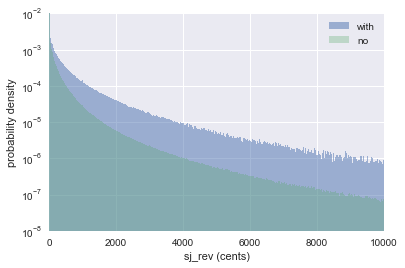

In [25]:
us.plot_result()

In [22]:
us_bar = multiplier_valuation(country='US', strict=False)

In [23]:
us_bar.compare_average()

with metric:  563
without metric:  93
difference:  470


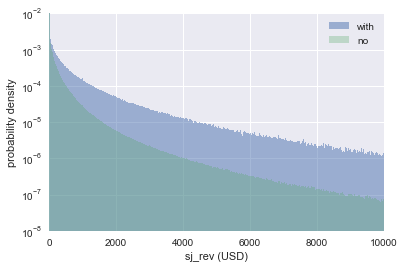

In [20]:
us_bar.plot_result()

In [95]:
class sj_dist(object):
    def __init__(self, metric='job_alert_creations', country='US', 
                 start='2017-01-01', end='2017-06-01', strict=True,
                 compare='sj_clicks'):
        self._metric = metric
        self._country = country
        self._start = start
        self._end = end
        self._no_metric = None
        self._with_metric = None
        self._strict = strict
        self._compare = compare
        
        
    def show_params(self):
        print self._metric, self._country, self._start, self._end
        
    def show_data(self):
        return dict(no_metric=self._no_metric, with_metric=self._with_metric)
    
    def clean_data(self, _data):
        data = _data[:]
        data.columns = [self._compare, 'count']
        data = data[data[self._compare].str.contains('\[')]
        data[self._compare] = data[self._compare].apply(lambda x: x[1:x.find(',')])
        data[self._compare] = data[self._compare].astype(int)
        data[self._compare] = data[self._compare]
        data[self._compare] = data[self._compare].astype(int)
        data['count'] = data['count'].astype(int)
        return data
    
    def get_average(self, data):
        return sum(data[self._compare]*data['count'])/sum(data['count'])
    
    def get_median(self, data):
        data = data[:]
        data['percentile'] = data['count'].cumsum()/sum(data['count'])
        return data
        
    def operator(self):
        if self._strict:
            return '='
        else:
            return '>='
        
    def query_builder(self, single=True):
        no_metric = ('from ctkcohort {0} {1} where first_eight_week_{2}=0 country="{3}" '
               'group by bucket(first_eight_week_{4},'
               '0,1000,1)').format(self._start, self._end, self._metric, self._country, self._compare)
        with_metric = ('from ctkcohort {0} {1} where first_eight_week_{2}{4}1 country="{3}" '
               'group by bucket(first_eight_week_{5},'
               '0,1000,1)').format(self._start, self._end, self._metric, 
                                          self._country, self.operator(), self._compare)
        return dict(no_metric=no_metric, with_metric=with_metric)
    
    def get_data(self):
        query = self.query_builder()
        if self._no_metric is None and self._with_metric is None:
            self._no_metric = iql.dataframe(query['no_metric'])
            self._with_metric = iql.dataframe(query['with_metric'])
    
    def compare_average(self):
        if self._no_metric is None and self._with_metric is None:
            self.get_data()
        with_metric = self.clean_data(self._with_metric)
        no_metric = self.clean_data(self._no_metric)
        with_metric_avg = self.get_average(with_metric)
        no_metric_avg = self.get_average(no_metric)
        print 'with metric: ', with_metric_avg
        print 'without metric: ', no_metric_avg
        print 'difference: ', with_metric_avg - no_metric_avg

        
    def plot_result(self, xlow=0, xhigh=1000, ylow=0, yhigh=1, bins=999):
        with_metric = self.clean_data(self._with_metric)
        no_metric = self.clean_data(self._no_metric)
        plt.xlim(xlow, xhigh)
        plt.ylim(ylow, yhigh) 
        bins2, edges2, _ = plt.hist(with_metric[self._compare], weights=with_metric['count'], bins=bins, 
                          normed=True, log=True, range=(xlow, xhigh), alpha=0.5, label='with'.format(self._metric))
        bins0, edges0, _ = plt.hist(no_metric[self._compare], weights=no_metric['count'], bins=bins, 
                          normed=True, log=True, range=(xlow, xhigh), alpha=0.3, label='no'.format(self._metric))
        plt.legend()
        plt.xlabel(self._compare)
        plt.ylabel('probability density')

In [99]:
x = sj_dist(country='US')

In [100]:
x.compare_average()

with metric:  8
without metric:  1
difference:  7


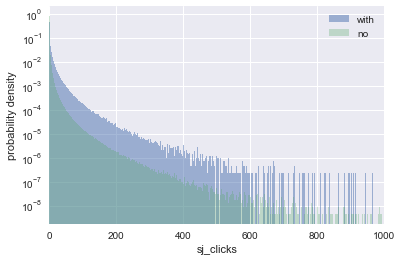

In [102]:
x.plot_result(xhigh=1000, ylow=10**-8, yhigh=0.1)

In [103]:
xx = sj_dist(country='US', compare='oj_clicks')
xx.compare_average()

with metric:  18
without metric:  3
difference:  15


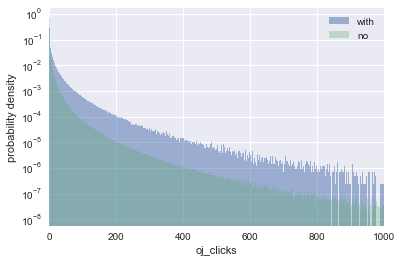

In [104]:
xx.plot_result()

In [105]:
xxx = sj_dist(country='US', compare='sessions')
xxx.compare_average()

with metric:  9
without metric:  2
difference:  7


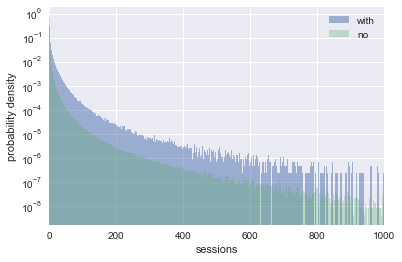

In [106]:
xxx.plot_result()

In [108]:
xxxx = sj_dist(country='US', compare='sj_impressions')
xxxx.compare_average()

with metric:  126
without metric:  35
difference:  91


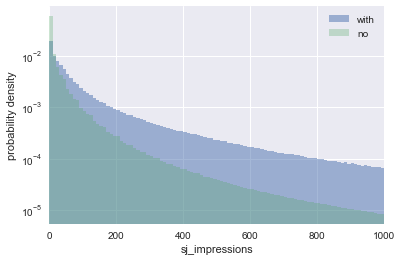

In [112]:
xxxx.plot_result(bins=100)

In [117]:
xxxx = sj_dist(country='US', compare='indeed_applies')
xxxx.compare_average()

with metric:  4
without metric:  0
difference:  4


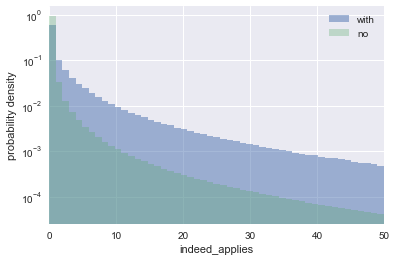

In [121]:
xxxx.plot_result(bins=51, xlow=0, xhigh=50)

In [95]:
class multiplier_valuation_first_day_only(object):
    def __init__(self, metric='job_alert_creations', country='US', start='2017-01-01', end='2017-04-01', strict=True):
        self._metric = metric
        self._country = country
        self._start = start
        self._end = end
        self._no_metric = None
        self._with_metric = None
        self._strict = strict
        
        
    def show_params(self):
        print self._metric, self._country, self._start, self._end
        
    def show_data(self):
        return dict(no_metric=self._no_metric, with_metric=self._with_metric)
    
    @staticmethod
    def clean_data(_data):
        data = _data[:]
        data.columns = ['sj_rev', 'count']
        data = data[data['sj_rev'].str.contains('\[')]
        data['sj_rev'] = data['sj_rev'].apply(lambda x: x[1:x.find(',')])
        data['sj_rev'] = data['sj_rev'].astype(int)
        data['sj_rev'] = data['sj_rev']/1000
        data['sj_rev'] = data['sj_rev'].astype(int)
        data['count'] = data['count'].astype(int)
        return data
    
    @staticmethod
    def get_average(data):
        return sum(data['sj_rev']*data['count'])/sum(data['count'])
    
    @staticmethod
    def get_median(data):
        data = data[:]
        data['percentile'] = data['count'].cumsum()/sum(data['count'])
        return data
        
    def operator(self):
        if self._strict:
            return '='
        else:
            return '>='
        
    def query_builder(self, single=True):
        no_metric = ('from ctkcohort {0} {1} where first_eight_week_{2}=0 country="{3}" '
               'group by bucket(first_eight_week_sj_revenue_millicents,'
               '0,10000000,1000)').format(self._start, self._end, self._metric, self._country)
        with_metric = ('from ctkcohort {0} {1} where first_day_{2}{4}1 country="{3}" '
                       'first_eight_week_{2}{4}1 group by bucket(first_eight_week_sj_revenue_millicents,'
                       '0,10000000,1000)').format(self._start, self._end, self._metric, 
                                          self._country, self.operator())
        return dict(no_metric=no_metric, with_metric=with_metric)
    
    def get_data(self):
        query = self.query_builder()
        if self._no_metric is None and self._with_metric is None:
            self._no_metric = iql.dataframe(query['no_metric'])
            self._with_metric = iql.dataframe(query['with_metric'])
    
    def compare_average(self):
        if self._no_metric is None and self._with_metric is None:
            self.get_data()
        with_metric = multiplier_valuation.clean_data(self._with_metric)
        no_metric = multiplier_valuation.clean_data(self._no_metric)
        with_metric_avg = multiplier_valuation.get_average(with_metric)
        no_metric_avg = multiplier_valuation.get_average(no_metric)
        print 'with metric: ', with_metric_avg
        print 'without metric: ', no_metric_avg
        print 'difference: ', with_metric_avg - no_metric_avg

        
    def plot_result(self):
        with_metric = multiplier_valuation.clean_data(self._with_metric)
        no_metric = multiplier_valuation.clean_data(self._no_metric)
        plt.xlim(0, 10000)
        plt.ylim(0.00000001, 0.01) 
        bins2, edges2, _ = plt.hist(with_metric['sj_rev'], weights=with_metric['count'], bins=999, 
                          normed=True, log=True, range=(0,10000), alpha=0.5, label='single JA'.format(self._metric))
        bins0, edges0, _ = plt.hist(no_metric['sj_rev'], weights=no_metric['count'], bins=999, 
                          normed=True, log=True, range=(0,10000), alpha=0.3, label='no JA'.format(self._metric))
        plt.legend()
        plt.xlabel('sj_rev (USD in cents)')
        plt.ylabel('probability density')

In [86]:
xs = multiplier_valuation_first_day_only()

In [87]:
xs.compare_average()

with metric:  238
without metric:  88
difference:  150


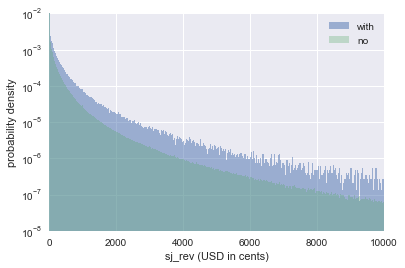

In [88]:
xs.plot_result()

In [96]:
xxs = multiplier_valuation_first_day_only(strict=True)

In [97]:
xxs.compare_average()

with metric:  195
without metric:  88
difference:  107


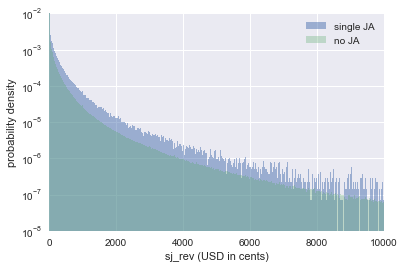

In [98]:
xxs.plot_result()

In [122]:
ddf = pd.read_csv('query_overlap.txt')

In [123]:
xxxx = ddf[ddf.dradis_clicks>1]
xxxx['query'] = xxxx['query'].apply(lambda x: '['+x+']')

/Users/aristotle/.pyenv/versions/2.7.9/envs/scratch/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [124]:
xxxx['query'].to_csv('test.txt', index=False)

In [125]:
len(xxxx['query'])

2659